# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# import gym
# import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
# batch[0], batch[0][1].shape

In [7]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [8]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [10]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [11]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [12]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [16]:
env.action_space, env.observation_space

(Discrete(2), Box(4,))

In [17]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [18]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# state = env.reset()

# for _ in range(memory_size):
#     action = env.action_space.sample()
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
import numpy as np

# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
loss_list = []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                next_states = np.array([each[2] for each in batch])
                rewards = np.array([each[3] for each in batch])
                dones = np.array([each[4] for each in batch])
                
                # targetQs
                next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
                nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
                targetQs = rewards + (gamma * nextQs)
                
                # Optimization
                loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs})
                loss_batch.append(loss)
                
            # End of episode
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

/home/arasdar/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arasdar/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode:0 meanR:16.0000 R:16.0 loss:nan exploreP:0.9984
Episode:1 meanR:31.0000 R:46.0 loss:1.2193 exploreP:0.9939
Episode:2 meanR:26.3333 R:17.0 loss:1.3051 exploreP:0.9922
Episode:3 meanR:26.0000 R:25.0 loss:1.2802 exploreP:0.9898
Episode:4 meanR:24.2000 R:17.0 loss:1.3213 exploreP:0.9881
Episode:5 meanR:21.8333 R:10.0 loss:1.3124 exploreP:0.9871
Episode:6 meanR:21.1429 R:17.0 loss:1.3305 exploreP:0.9855
Episode:7 meanR:20.6250 R:17.0 loss:1.2912 exploreP:0.9838
Episode:8 meanR:20.8889 R:23.0 loss:1.3417 exploreP:0.9816
Episode:9 meanR:19.9000 R:11.0 loss:1.3472 exploreP:0.9805
Episode:10 meanR:20.5455 R:27.0 loss:1.3822 exploreP:0.9779
Episode:11 meanR:20.4167 R:19.0 loss:1.4152 exploreP:0.9760
Episode:12 meanR:20.0769 R:16.0 loss:1.4614 exploreP:0.9745
Episode:13 meanR:19.9286 R:18.0 loss:1.5077 exploreP:0.9728
Episode:14 meanR:20.5333 R:29.0 loss:1.5789 exploreP:0.9700
Episode:15 meanR:20.0625 R:13.0 loss:1.6804 exploreP:0.9687
Episode:16 meanR:19.4118 R:9.0 loss:1.7033 exploreP:0

Episode:135 meanR:19.2400 R:28.0 loss:21.9746 exploreP:0.7686
Episode:136 meanR:19.2600 R:26.0 loss:32.0840 exploreP:0.7667
Episode:137 meanR:19.2700 R:15.0 loss:31.5056 exploreP:0.7655
Episode:138 meanR:19.2000 R:13.0 loss:25.8596 exploreP:0.7645
Episode:139 meanR:19.1200 R:10.0 loss:18.5145 exploreP:0.7638
Episode:140 meanR:19.1400 R:17.0 loss:30.8268 exploreP:0.7625
Episode:141 meanR:19.1400 R:22.0 loss:24.6331 exploreP:0.7608
Episode:142 meanR:19.1400 R:11.0 loss:34.4824 exploreP:0.7600
Episode:143 meanR:19.3200 R:29.0 loss:32.0938 exploreP:0.7579
Episode:144 meanR:19.5000 R:33.0 loss:32.1751 exploreP:0.7554
Episode:145 meanR:19.1700 R:18.0 loss:34.7152 exploreP:0.7540
Episode:146 meanR:19.1600 R:20.0 loss:24.6514 exploreP:0.7526
Episode:147 meanR:19.2900 R:23.0 loss:33.5393 exploreP:0.7509
Episode:148 meanR:19.2900 R:19.0 loss:24.9856 exploreP:0.7494
Episode:149 meanR:19.2200 R:10.0 loss:47.4068 exploreP:0.7487
Episode:150 meanR:18.8700 R:12.0 loss:39.0653 exploreP:0.7478
Episode:

Episode:271 meanR:22.4800 R:18.0 loss:14.6041 exploreP:0.5752
Episode:272 meanR:22.6100 R:24.0 loss:14.5327 exploreP:0.5739
Episode:273 meanR:22.8900 R:44.0 loss:14.6996 exploreP:0.5714
Episode:274 meanR:23.0700 R:30.0 loss:11.9105 exploreP:0.5697
Episode:275 meanR:23.2700 R:39.0 loss:10.3079 exploreP:0.5675
Episode:276 meanR:23.4700 R:38.0 loss:13.5578 exploreP:0.5654
Episode:277 meanR:23.6100 R:33.0 loss:14.3756 exploreP:0.5636
Episode:278 meanR:23.7300 R:27.0 loss:15.1996 exploreP:0.5621
Episode:279 meanR:24.1200 R:52.0 loss:11.0930 exploreP:0.5592
Episode:280 meanR:24.2700 R:31.0 loss:14.7022 exploreP:0.5575
Episode:281 meanR:24.6300 R:48.0 loss:13.1335 exploreP:0.5549
Episode:282 meanR:25.8300 R:132.0 loss:14.5799 exploreP:0.5478
Episode:283 meanR:25.8400 R:50.0 loss:10.1810 exploreP:0.5451
Episode:284 meanR:25.9700 R:53.0 loss:14.3148 exploreP:0.5422
Episode:285 meanR:26.2500 R:45.0 loss:14.2127 exploreP:0.5399
Episode:286 meanR:26.7000 R:62.0 loss:15.2338 exploreP:0.5366
Episode

Episode:403 meanR:56.1100 R:83.0 loss:31.1332 exploreP:0.2880
Episode:404 meanR:56.2300 R:67.0 loss:22.1772 exploreP:0.2861
Episode:405 meanR:56.3600 R:47.0 loss:30.6531 exploreP:0.2848
Episode:406 meanR:56.9600 R:95.0 loss:31.8682 exploreP:0.2822
Episode:407 meanR:57.2700 R:71.0 loss:34.5552 exploreP:0.2803
Episode:408 meanR:57.7300 R:67.0 loss:37.2208 exploreP:0.2785
Episode:409 meanR:58.1100 R:79.0 loss:41.0729 exploreP:0.2764
Episode:410 meanR:58.1800 R:57.0 loss:31.6031 exploreP:0.2749
Episode:411 meanR:58.3200 R:64.0 loss:39.9237 exploreP:0.2732
Episode:412 meanR:58.6000 R:141.0 loss:32.4756 exploreP:0.2695
Episode:413 meanR:59.6000 R:137.0 loss:34.0973 exploreP:0.2660
Episode:414 meanR:59.9300 R:73.0 loss:28.8780 exploreP:0.2641
Episode:415 meanR:59.9100 R:57.0 loss:34.6087 exploreP:0.2626
Episode:416 meanR:60.1700 R:58.0 loss:26.2439 exploreP:0.2612
Episode:417 meanR:60.4700 R:117.0 loss:33.8400 exploreP:0.2583
Episode:418 meanR:61.0000 R:115.0 loss:27.2397 exploreP:0.2554
Epis

Episode:533 meanR:287.2200 R:466.0 loss:56.0642 exploreP:0.0220
Episode:534 meanR:291.2600 R:500.0 loss:71.8558 exploreP:0.0215
Episode:535 meanR:295.7300 R:500.0 loss:70.8597 exploreP:0.0209
Episode:536 meanR:298.9100 R:408.0 loss:59.4845 exploreP:0.0205
Episode:537 meanR:302.6900 R:500.0 loss:59.7557 exploreP:0.0199
Episode:538 meanR:305.0400 R:334.0 loss:54.0427 exploreP:0.0196
Episode:539 meanR:308.3000 R:419.0 loss:66.5374 exploreP:0.0192
Episode:540 meanR:311.3300 R:370.0 loss:55.6057 exploreP:0.0189
Episode:541 meanR:314.7300 R:402.0 loss:68.4268 exploreP:0.0185
Episode:542 meanR:318.4600 R:457.0 loss:68.3156 exploreP:0.0182
Episode:543 meanR:319.6500 R:500.0 loss:52.7260 exploreP:0.0178
Episode:544 meanR:322.2800 R:336.0 loss:68.5816 exploreP:0.0175
Episode:545 meanR:323.7200 R:381.0 loss:71.3310 exploreP:0.0172
Episode:546 meanR:327.3600 R:500.0 loss:69.4035 exploreP:0.0169
Episode:547 meanR:331.6900 R:500.0 loss:65.0232 exploreP:0.0165
Episode:548 meanR:334.0400 R:500.0 loss:

Episode:662 meanR:425.6500 R:474.0 loss:29.1102 exploreP:0.0100
Episode:663 meanR:426.9000 R:469.0 loss:35.0358 exploreP:0.0100
Episode:664 meanR:428.6200 R:500.0 loss:36.0585 exploreP:0.0100
Episode:665 meanR:427.2800 R:366.0 loss:35.9288 exploreP:0.0100
Episode:666 meanR:427.2800 R:500.0 loss:33.1155 exploreP:0.0100
Episode:667 meanR:427.2800 R:500.0 loss:25.3221 exploreP:0.0100
Episode:668 meanR:427.2800 R:500.0 loss:27.1858 exploreP:0.0100
Episode:669 meanR:427.2800 R:500.0 loss:31.1803 exploreP:0.0100
Episode:670 meanR:426.5300 R:283.0 loss:34.5591 exploreP:0.0100
Episode:671 meanR:424.4700 R:294.0 loss:31.3540 exploreP:0.0100
Episode:672 meanR:423.3600 R:276.0 loss:31.3814 exploreP:0.0100
Episode:673 meanR:421.1400 R:278.0 loss:26.9182 exploreP:0.0100
Episode:674 meanR:421.9100 R:412.0 loss:33.0296 exploreP:0.0100
Episode:675 meanR:421.9100 R:500.0 loss:19.3693 exploreP:0.0100
Episode:676 meanR:422.6100 R:493.0 loss:26.9788 exploreP:0.0100
Episode:677 meanR:423.3700 R:500.0 loss:

Episode:789 meanR:412.6400 R:500.0 loss:1136.2684 exploreP:0.0100
Episode:790 meanR:414.9800 R:500.0 loss:1455.9821 exploreP:0.0100
Episode:791 meanR:417.4000 R:500.0 loss:1507.7860 exploreP:0.0100
Episode:792 meanR:418.5500 R:368.0 loss:1143.2352 exploreP:0.0100
Episode:793 meanR:418.5500 R:500.0 loss:1251.8428 exploreP:0.0100
Episode:794 meanR:416.6700 R:195.0 loss:1552.1798 exploreP:0.0100
Episode:795 meanR:413.6400 R:197.0 loss:1531.9114 exploreP:0.0100
Episode:796 meanR:412.8300 R:208.0 loss:1567.2716 exploreP:0.0100
Episode:797 meanR:415.6100 R:500.0 loss:1780.1071 exploreP:0.0100
Episode:798 meanR:415.6100 R:500.0 loss:1956.1508 exploreP:0.0100
Episode:799 meanR:417.8000 R:500.0 loss:1949.9167 exploreP:0.0100
Episode:800 meanR:418.2800 R:500.0 loss:1873.3478 exploreP:0.0100
Episode:801 meanR:418.2800 R:500.0 loss:1730.3107 exploreP:0.0100
Episode:802 meanR:418.5300 R:309.0 loss:1719.1436 exploreP:0.0100
Episode:803 meanR:419.9600 R:500.0 loss:1652.2253 exploreP:0.0100
Episode:80

Episode:914 meanR:416.1500 R:318.0 loss:1108.3600 exploreP:0.0100
Episode:915 meanR:414.9300 R:378.0 loss:1250.0551 exploreP:0.0100
Episode:916 meanR:416.0200 R:500.0 loss:1299.2563 exploreP:0.0100
Episode:917 meanR:415.9200 R:469.0 loss:1268.9718 exploreP:0.0100
Episode:918 meanR:415.8200 R:423.0 loss:1306.3209 exploreP:0.0100
Episode:919 meanR:415.4000 R:453.0 loss:1199.6560 exploreP:0.0100
Episode:920 meanR:415.0900 R:408.0 loss:1178.8264 exploreP:0.0100
Episode:921 meanR:415.1800 R:437.0 loss:1221.3381 exploreP:0.0100
Episode:922 meanR:415.6000 R:500.0 loss:1270.1541 exploreP:0.0100
Episode:923 meanR:416.9800 R:500.0 loss:1187.1433 exploreP:0.0100
Episode:924 meanR:417.9600 R:455.0 loss:1220.4963 exploreP:0.0100
Episode:925 meanR:417.8400 R:391.0 loss:1374.4142 exploreP:0.0100
Episode:926 meanR:417.4700 R:380.0 loss:1162.3334 exploreP:0.0100
Episode:927 meanR:419.0400 R:500.0 loss:1183.0085 exploreP:0.0100
Episode:928 meanR:420.0800 R:500.0 loss:1260.6176 exploreP:0.0100
Episode:92

Episode:1040 meanR:475.0300 R:467.0 loss:9.9779 exploreP:0.0100
Episode:1041 meanR:474.6000 R:417.0 loss:17.7646 exploreP:0.0100
Episode:1042 meanR:475.2400 R:500.0 loss:13.2462 exploreP:0.0100
Episode:1043 meanR:475.2400 R:500.0 loss:7.3489 exploreP:0.0100
Episode:1044 meanR:477.0800 R:500.0 loss:7.0583 exploreP:0.0100
Episode:1045 meanR:478.4300 R:500.0 loss:14.7958 exploreP:0.0100
Episode:1046 meanR:478.2200 R:479.0 loss:9.1515 exploreP:0.0100
Episode:1047 meanR:478.4500 R:473.0 loss:20.2853 exploreP:0.0100
Episode:1048 meanR:478.4500 R:500.0 loss:17.6530 exploreP:0.0100
Episode:1049 meanR:479.7400 R:500.0 loss:19.7881 exploreP:0.0100
Episode:1050 meanR:480.9500 R:500.0 loss:14.2244 exploreP:0.0100
Episode:1051 meanR:480.5800 R:420.0 loss:26.7270 exploreP:0.0100
Episode:1052 meanR:480.5800 R:500.0 loss:14.3352 exploreP:0.0100
Episode:1053 meanR:480.5800 R:500.0 loss:9.4784 exploreP:0.0100
Episode:1054 meanR:480.5800 R:500.0 loss:13.1270 exploreP:0.0100
Episode:1055 meanR:479.6000 R:

Episode:1167 meanR:479.4800 R:500.0 loss:6.6685 exploreP:0.0100
Episode:1168 meanR:479.4800 R:500.0 loss:7.4334 exploreP:0.0100
Episode:1169 meanR:479.4800 R:500.0 loss:12.3949 exploreP:0.0100
Episode:1170 meanR:480.0300 R:492.0 loss:4.1986 exploreP:0.0100
Episode:1171 meanR:480.0300 R:500.0 loss:5.3171 exploreP:0.0100
Episode:1172 meanR:479.5400 R:421.0 loss:6.1997 exploreP:0.0100
Episode:1173 meanR:479.0300 R:449.0 loss:9.3848 exploreP:0.0100
Episode:1174 meanR:479.0300 R:500.0 loss:9.3851 exploreP:0.0100
Episode:1175 meanR:479.9400 R:500.0 loss:8.7472 exploreP:0.0100
Episode:1176 meanR:479.5700 R:451.0 loss:8.6047 exploreP:0.0100
Episode:1177 meanR:479.5700 R:500.0 loss:5.6436 exploreP:0.0100
Episode:1178 meanR:479.8200 R:500.0 loss:8.6769 exploreP:0.0100
Episode:1179 meanR:480.0800 R:500.0 loss:6.7101 exploreP:0.0100
Episode:1180 meanR:480.5400 R:483.0 loss:7.0698 exploreP:0.0100
Episode:1181 meanR:480.7800 R:500.0 loss:8.2917 exploreP:0.0100
Episode:1182 meanR:480.2100 R:443.0 los

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

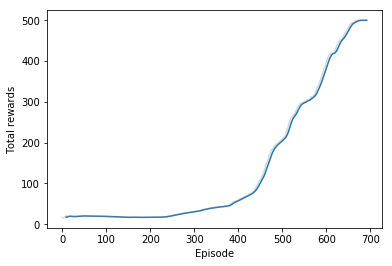

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

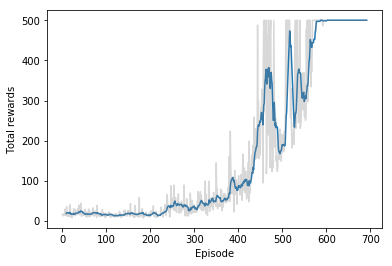

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

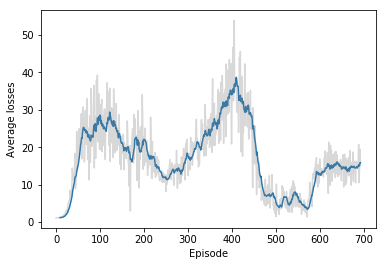

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

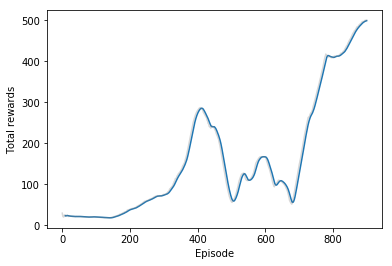

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

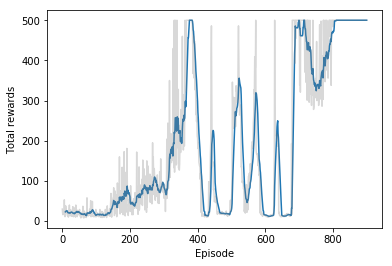

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

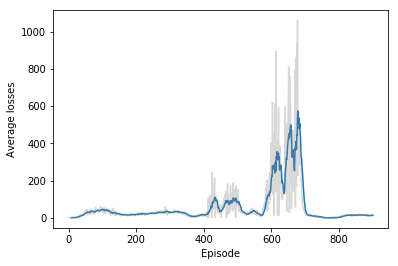

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.